Möchten Sie Parameter aus einer Datei laden (l) oder neue Parameter eingeben (n)?  l


0: params/default_params.json
1: params/params.json
Welche Datei soll geladen werden? (0 bis 1)


>  0


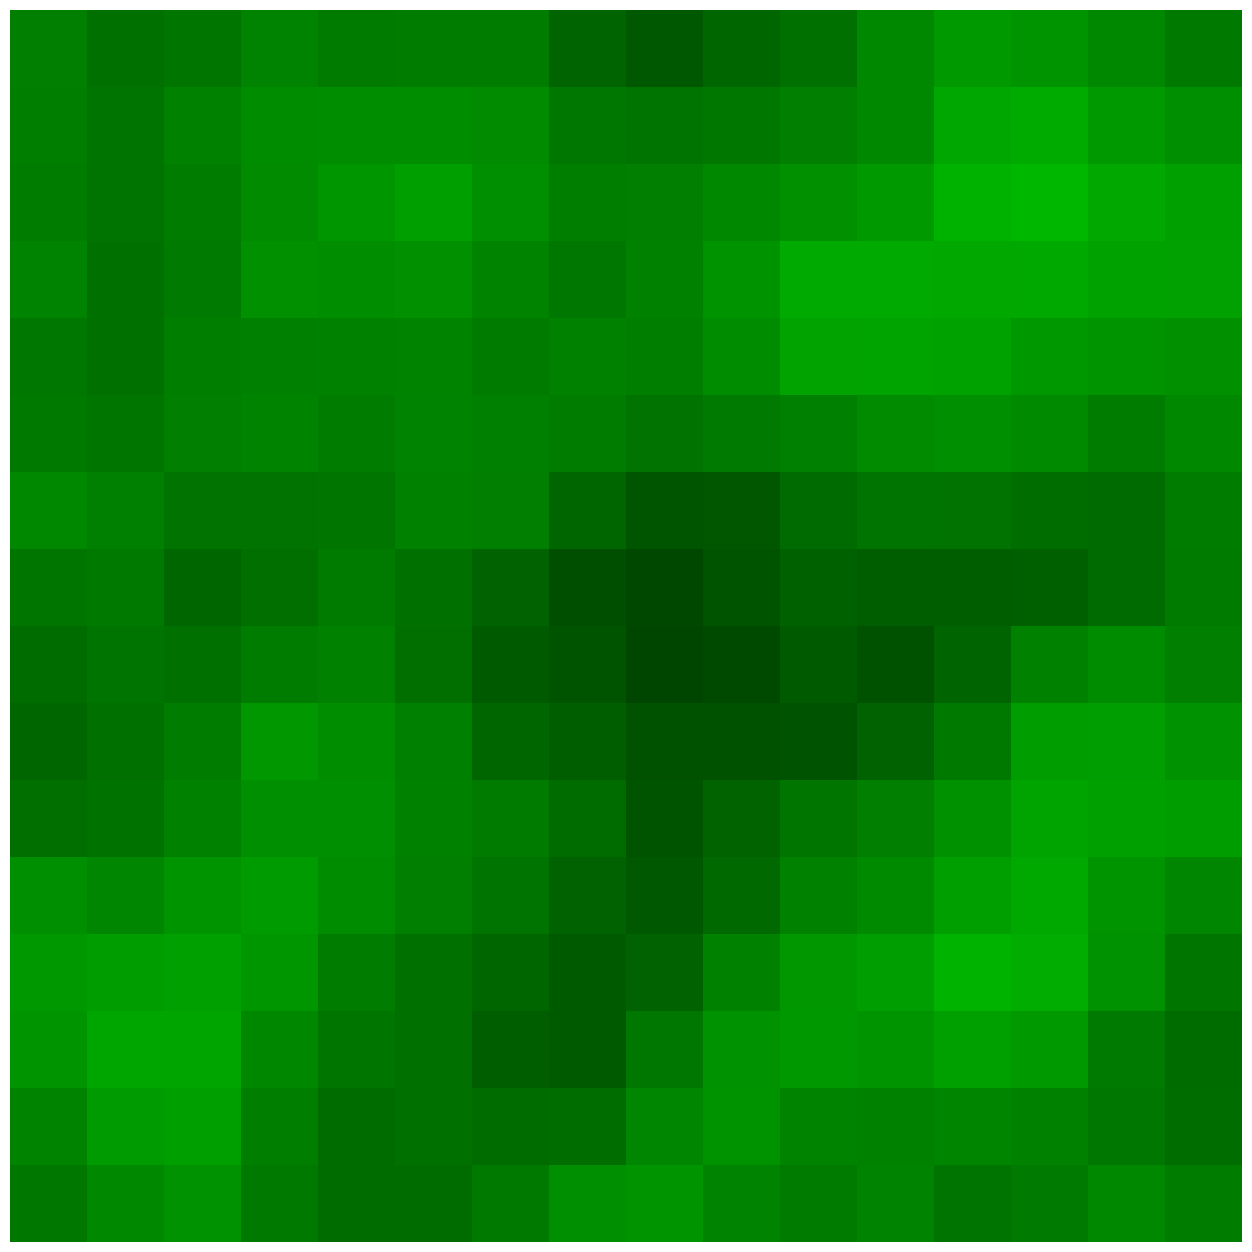

MovieWriter ffmpeg unavailable; using Pillow instead.


export/animation.gif gespeichert


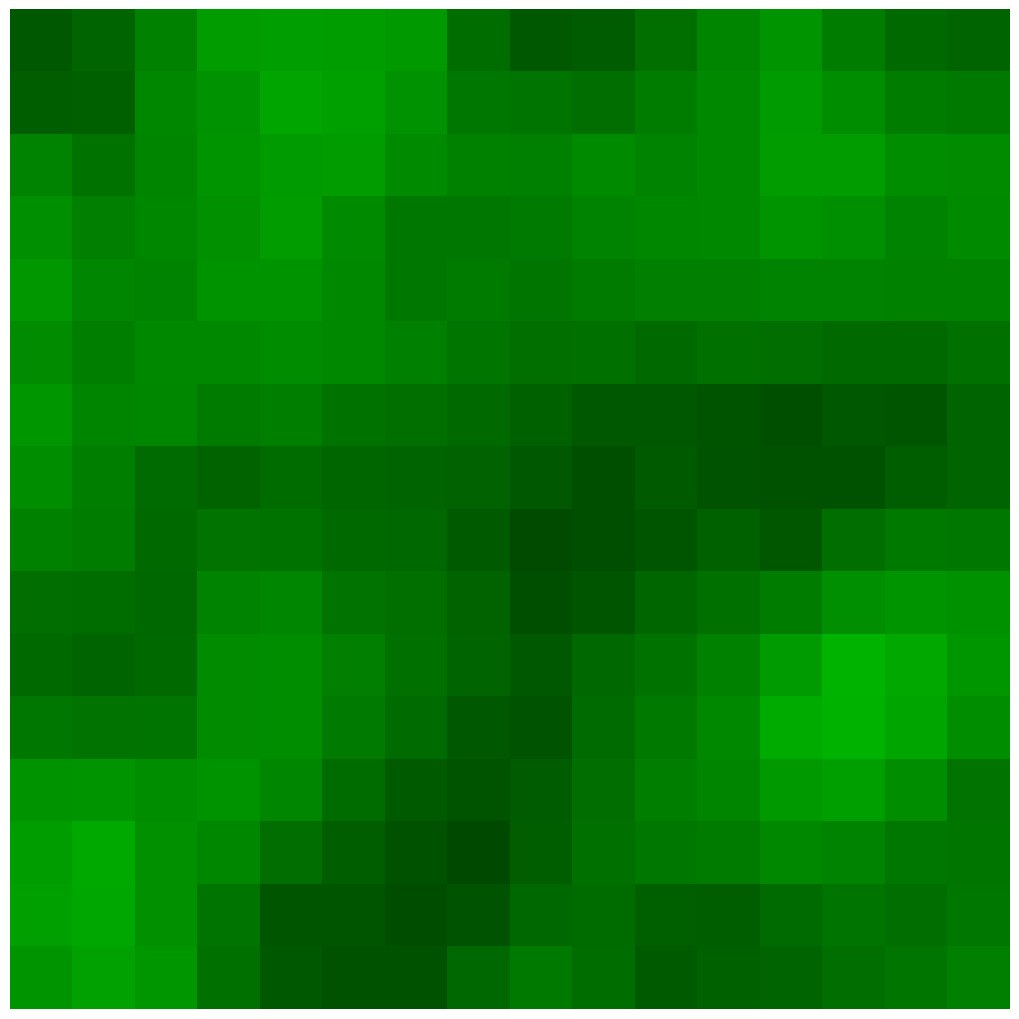

In [4]:
#import utils.functions as func

import src.file_handling as file_handling
import src.animation_generation as animation_generation
import src.image_generation as image_generation
import src.user_interface as user_interface

import matplotlib.pyplot as plt

def main():
    """
    Hauptfunktion des Skripts.

    Initialisiert die Parameter, generiert ein Bild, zeigt es an, erstellt eine Animation und speichert sie in einer Datei.
    """
    
    auswahl = user_interface.benutzer_parameter_abfrage()
    
    if auswahl == 'n':
        # User Eingabe zur Bestimmung der Parameter
        params_datei = user_interface.benutzer_parameter_eingabe_und_speichern()
            
    else:
        # User Eingabe zur Auswahl der params Datei
        params_datei = user_interface.user_params_datei_auswahl()

    # Laden Sie die Parameter aus der Datei
    params = file_handling.laden_params(params_datei)

    # Speichern Sie die Parameter in einer Datei
    file_handling.speichern_params(params, 'params/params.json')

    # Laden Sie die Parameter aus der Datei
    #params = file_handling.laden_params('params/params.json')

    # Generieren Sie ein Bild
    image = image_generation.generiere_bild(params)
        
    # Zeige das Bild an
    image_generation.show_image(image, (16, 16))

    # Erstelle und speichere die Animation
    animation_generation.erstelle_und_speichere_animation(params, 'export/animation.gif', (10,10))

if __name__ == "__main__":
    main()